# Behavioral Cloning-Project

## Driving data set

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import sklearn
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from keras.layers import Input, Conv2D, Cropping2D, Lambda, Dense, Flatten
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.optimizers import Nadam

from src import get_driving_data, \
    steering_image_batch_generator, \
    ResizeImages

Using TensorFlow backend.


### Load data

In [2]:
data_dir = os.path.join('/home', 'Simulation_Data')
log_csv = os.path.join(data_dir, 'driving_log.csv')

driving_df = get_driving_data(log_csv)
print(driving_df.loc[5])  # print random example to check that data is as expected

Center image    IMG/center_2018_10_20_21_50_37_206.jpg
Left image        IMG/left_2018_10_20_21_50_37_206.jpg
Right image      IMG/right_2018_10_20_21_50_37_206.jpg
Steering                                     -0.122066
Name: 5, dtype: object


### Exploring data

In [3]:
n_samples = driving_df.shape[0]
steering_df = driving_df['Steering']
mean_steering = steering_df.mean()
min_steering = steering_df.min()
max_steering = steering_df.max()
print(f'number of steering angles recorded: {n_samples} x 3 = {n_samples*3}'
      f'\nmin steering angle: {min_steering}'
      f'\nmax steering angle: {max_steering}'
      f'\nmean steering angle: {mean_steering}')

number of steering angles recorded: 9742 x 3 = 29226
min steering angle: -1.0
max steering angle: 1.0
mean steering angle: -0.0011161202688359676


Data shows that steering angles in the driving log are already normalized to be in range between -1 and 1. For demonstration purpose I also want to look at the real angles which means that angles have to be scaled back.
The normalization code can be found here: [GitHub udacity/self-driving-car-sim](https://github.com/udacity/self-driving-car-sim/blob/bdcd588990df2db4706e772cd45d6e013631a2f2/Assets/Standard%20Assets/Vehicles/Car/Scripts/CarController.cs#L472). So, all angles are divided by the maximum steering angle before logging which equals 25° in the present version of the simulator.

In [4]:
real_angles_df = steering_df*25.0
mean_angle = real_angles_df.mean()
min_angle = real_angles_df.min()
max_angle = real_angles_df.max()
print(f'\nmin steering angle: {min_angle}'
      f'\nmax steering angle: {max_angle}'
      f'\nmean steering angle: {mean_angle}')


min steering angle: -25.0
max steering angle: 25.0
mean steering angle: -0.02790300672089913


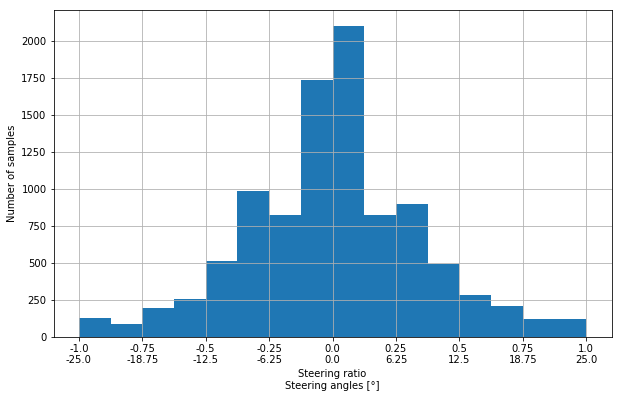

In [5]:
tick_count = 9
angles_hist = real_angles_df.plot.hist(figsize=(10, 6), bins=16, grid=True)

angles_hist.set_xlabel('Steering ratio\nSteering angles [°]')
angles_hist.set_ylabel('Number of samples')

angles_ticks = np.linspace(min_angle, max_angle, tick_count)
angles_hist.set_xticks(angles_ticks)
steering_ticks = np.linspace(min_steering, max_steering, tick_count)
angles_hist.set_xticklabels([f'{steering_ticks[i]}\n{angles_ticks[i]}' for i in range(tick_count)])

plt.show()

In order to take advantage of the three cameras, I create a new data frame where the side images are not arranged as columns but are appended as new rows. Thus, threating them as independent images that have own steering angles which are calculated through an offset. This keeps batch generation simple as it just adds more samples and we do not have to deal with columns.

In [6]:
cameras = ['Center', 'Left', 'Right']
camera_steering_offsets = [0.0, 0.2, -0.2]
camera_dataframes = [
    driving_df[[f'{cam} image', 'Steering']] \
        .rename(columns={f'{cam} image': 'Image'}) \
    for cam in cameras
]
for idx, offset in enumerate(camera_steering_offsets):
    camera_dataframes[idx]['Steering'] += offset

# Checking that the mean steering angles are in fact different by the offset:
means = [df['Steering'].mean() for df in camera_dataframes]
print(f'mean steering angles by cameras:\n{cameras}\n{str(means)}\n')

# Not needed but documents the structure of the resulting dataframe:
full_df = pd.DataFrame(data=[], columns=['Image', 'Steering'])

# Merge all dataframes into one
full_df = pd.concat(camera_dataframes)

print(full_df.shape)

mean steering angles by cameras:
['Center', 'Left', 'Right']
[-0.0011161202688359676, 0.19888387973116403, -0.201116120268836]

(29226, 2)


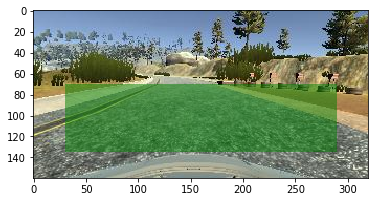

In [7]:
# Plot sample image
sample_image_name = driving_df.loc[152]['Center image']  # randomly chosen index
sample_image_file = os.path.join(data_dir, sample_image_name)
sample_image = cv2.imread(sample_image_file)

plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))

# Determine region of interest for cropping
original_image_height = sample_image.shape[0]
original_image_width = sample_image.shape[1]

left_crop = 30
right_crop = 30
bottom_crop = 25
top_crop = 70

left = left_crop
right = original_image_width - right_crop
bottom = original_image_height - bottom_crop
top = top_crop

rect = np.array([
    [left, top],
    [right, top],
    [right, bottom],
    [left, bottom]
])
rect_x = rect[:,0]-.5  # substract small amount to prevent plot from expanding into whitespace
rect_y = rect[:,1]

# Plot region of interest on top of sample image
plt.fill(rect_x, rect_y, facecolor='green', alpha=.5)

### Create train and validation sets from driving data

In [8]:
# Create training and validation dataset
train_set, validation_set = train_test_split(full_df.values, test_size=0.2)

# Also create a smaller training and validation dataset for testing models
part_df = full_df[:500].copy()
small_train_set, small_validation_set = train_test_split(part_df.values, test_size=0.3)

In [9]:
print(train_set[0:5])

[['IMG/center_2018_10_20_22_26_25_187.jpg' -0.36150229999999994]
 ['IMG/left_2018_10_20_22_32_52_057.jpg' 0.209389671]
 ['IMG/right_2018_10_20_22_24_18_003.jpg' 0.1849765]
 ['IMG/right_2018_10_20_22_18_49_604.jpg' -0.6647887]
 ['IMG/center_2018_10_20_22_33_08_721.jpg' 0.600939]]


## PilotNet model

In [10]:
BATCH_SIZE = 32

In [11]:
import time


def get_log_dir(base_path='./logs/PilotNet', path_suffix=None):
    localtime = time.localtime()
    datetime_string = time.strftime("%Y-%m-%d_%H-%M-%S", localtime)
    if path_suffix is not None:
        return f'{base_path}/{path_suffix}/{datetime_string}'
    return f'{base_path}/{datetime_string}'
    

def create_model():
    image_height = 66
    image_width = 200

    input_layer = Input(shape=(original_image_height, original_image_width, 3), name='input_image')

    # Crop the input image first, then normalize it.
    x = Cropping2D(cropping=((top_crop, bottom_crop), (left_crop, right_crop)), name='image_cropping')(input_layer)
    x = ResizeImages((image_height, image_width), name='image_resize')(x)
    x = Lambda(lambda n: n/127.5 - 1.0, name='image_normalization')(x)

    x = Conv2D(24, (5, 5), strides=(2, 2), activation='relu', name='conv1')(x)
    x = Conv2D(36, (5, 5), strides=(2, 2), activation='relu', name='conv2')(x)
    x = Conv2D(48, (5, 5), strides=(2, 2), activation='relu', name='conv3')(x)
    x = Conv2D(64, (3, 3), activation='relu', name='conv4')(x)
    x = Conv2D(64, (3, 3), activation='relu', name='conv5')(x)
    x = Flatten(name='flatten')(x)
    x = Dense(100, name='dense1')(x)
    x = Dense(50, name='dense2')(x)
    x = Dense(10, name='dense3')(x)
    x = Dense(1, name='output_angle')(x)

    model = Model(input=input_layer, output=x)
    opt = Nadam(lr=.001)
    model.compile(loss='mse', optimizer=opt)
    
    return model

Summary of the architecture:

In [12]:
debug_model = create_model()
debug_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     (None, 160, 320, 3)       0         
_________________________________________________________________
image_cropping (Cropping2D)  (None, 65, 260, 3)        0         
_________________________________________________________________
image_resize (ResizeImages)  (None, 66, 200, 3)        0         
_________________________________________________________________
image_normalization (Lambda) (None, 66, 200, 3)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 47, 36)        21636     
_________________________________________________________________
conv3 (Conv2D)               (None, 5, 22, 48)         43248     
__________

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`


Training the model on a small subset of data in memory to check and debug the model architecture using TensorBoard if something shows unexpected behavior:

In [13]:
tensorboard = TensorBoard(log_dir=get_log_dir(path_suffix='/debug'),
                          batch_size=BATCH_SIZE,
                          write_images=True,
                          write_graph=True,
                          write_grads=True,
                          histogram_freq=1)
checkpoint = ModelCheckpoint('PilotNet_Debug.h5', monitor='val_loss', verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1, mode='auto')

images, steering = [], []
for row in small_train_set:
    image_data = cv2.imread(os.path.join(data_dir, row[0]))
    images.append(image_data)
    steering.append(row[1])
x_train, y_train = np.array(images), np.array(steering)

images, steering = [], []
for row in small_validation_set:
    image_data = cv2.imread(os.path.join(data_dir, row[0]))
    images.append(image_data)
    steering.append(row[1])
x_validation, y_validation = np.array(images), np.array(steering)

debug_model.fit(x_train, y_train,
                validation_data=(x_validation, y_validation),
                batch_size=BATCH_SIZE,
                epochs=5,
                callbacks=[tensorboard, checkpoint, early])

Train on 350 samples, validate on 150 samples
Epoch 1/5
350/350 [==============================] - 2s 5ms/step - loss: 0.0262 - val_loss: 0.0019

Epoch 00001: val_loss improved from inf to 0.00193, saving model to PilotNet_Debug.h5
Epoch 2/5
350/350 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0022

Epoch 00002: val_loss did not improve from 0.00193
Epoch 3/5
350/350 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0013

Epoch 00003: val_loss improved from 0.00193 to 0.00133, saving model to PilotNet_Debug.h5
Epoch 4/5
350/350 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0011

Epoch 00004: val_loss improved from 0.00133 to 0.00113, saving model to PilotNet_Debug.h5
Epoch 5/5
350/350 [==============================] - 0s 1ms/step - loss: 9.3561e-04 - val_loss: 0.0010

Epoch 00005: val_loss improved from 0.00113 to 0.00102, saving model to PilotNet_Debug.h5


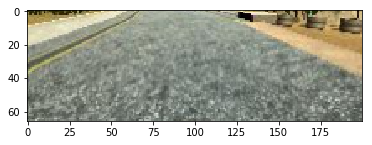

In [14]:
layer_name = 'image_resize'
intermediate_layer_model = Model(inputs=debug_model.input,
                                 outputs=debug_model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(x_train[None, 40])
output_image = cv2.cvtColor(intermediate_output[0].astype(np.uint8), cv2.COLOR_BGR2RGB)
plt.imshow(output_image)

In [15]:
test_prediction = debug_model.predict(x_train[0:10])
print(test_prediction)

[[-0.08128155]
 [-0.07264621]
 [-0.06686936]
 [-0.03239236]
 [-0.03240755]
 [-0.08048347]
 [-0.01662602]
 [-0.01447852]
 [-0.02936007]
 [-0.00937199]]


Training on the full dataset with image augmentation which takes longer:

In [16]:
train_generator = steering_image_batch_generator(data_dir, train_set)
validation_generator = steering_image_batch_generator(data_dir, validation_set)

epoch_steps_train = len(train_set)//BATCH_SIZE
epoch_steps_validation = len(validation_set)//BATCH_SIZE

tensorboard = TensorBoard(log_dir=get_log_dir(),
                                  batch_size=BATCH_SIZE,
                                  write_graph=False)
# Save the model according to the conditions
checkpoint = ModelCheckpoint('PilotNet.h5', monitor='val_loss', verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1, mode='auto')

model = create_model()
model.fit_generator(train_generator,
                    validation_data=validation_generator,
                    epochs=20,
                    steps_per_epoch=epoch_steps_train,
                    validation_steps=epoch_steps_validation,
                    callbacks=[tensorboard, checkpoint, early])

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`


Epoch 1/20
730/730 [==============================] - 40s 55ms/step - loss: 0.0427 - val_loss: 0.0324

Epoch 00001: val_loss improved from inf to 0.03238, saving model to PilotNet.h5
Epoch 2/20
730/730 [==============================] - 35s 47ms/step - loss: 0.0269 - val_loss: 0.0218

Epoch 00002: val_loss improved from 0.03238 to 0.02179, saving model to PilotNet.h5
Epoch 3/20
730/730 [==============================] - 34s 47ms/step - loss: 0.0207 - val_loss: 0.0216

Epoch 00003: val_loss improved from 0.02179 to 0.02160, saving model to PilotNet.h5
Epoch 4/20
730/730 [==============================] - 34s 47ms/step - loss: 0.0164 - val_loss: 0.0180

Epoch 00004: val_loss improved from 0.02160 to 0.01796, saving model to PilotNet.h5
Epoch 5/20
730/730 [==============================] - 34s 47ms/step - loss: 0.0143 - val_loss: 0.0157

Epoch 00005: val_loss improved from 0.01796 to 0.01567, saving model to PilotNet.h5
Epoch 6/20
730/730 [==============================] - 34s 47ms/step -

In [17]:
prediction = model.predict(x_train[0:10])
print(prediction)

[[0.08256767]
 [0.35429314]
 [0.45324817]
 [1.0414493 ]
 [0.9471943 ]
 [0.28883916]
 [0.6009016 ]
 [0.13000375]
 [0.86049074]
 [0.3016411 ]]


118.5452734375
128.19397786458333
122.80184895833334
116.54560546875
114.12817057291667
119.55577473958333


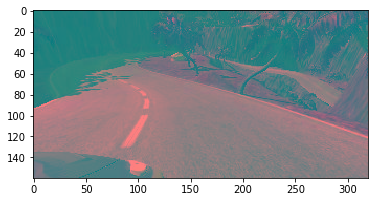

In [18]:
for i, test in enumerate(train_generator):
    if i > 5:
        break
    print(np.mean(test[0][0]))
    plt.imshow(test[0][0])